In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
from pathlib import Path

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.neuroscopeio import NeuroscopeIO
from neuropy.io.binarysignalio import BinarysignalIO 
from neuropy.io.miniscopeio import MiniscopeIO


# Test `alignment_util` functions

<IPython.core.display.Javascript object>


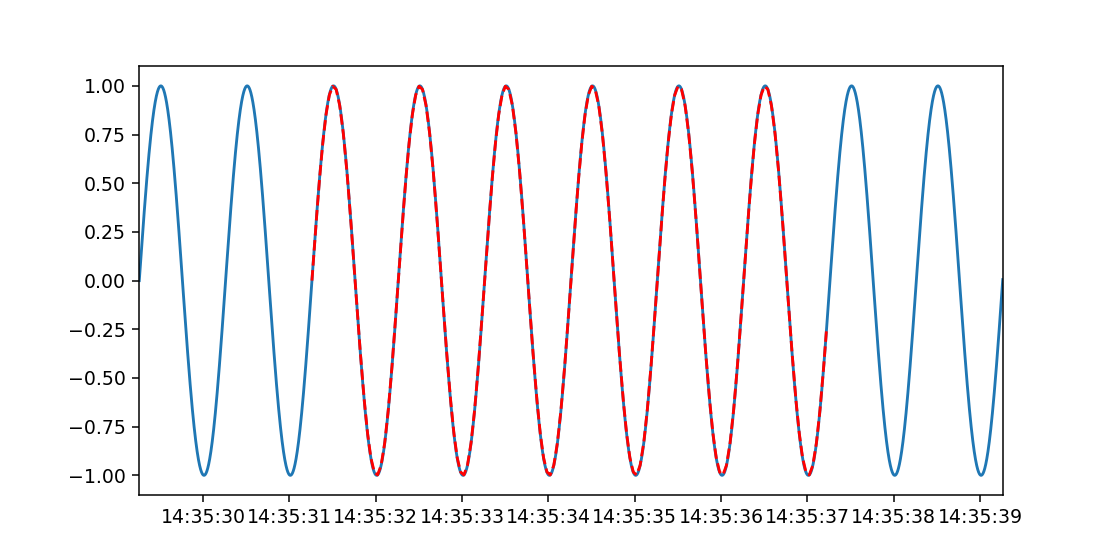

No alignment events input, aligning by timestamps directly


In [7]:
# Set up situation where you have identical data in both the ephys and position tracking system, but one is started after the other
from neuropy.utils.align_util import align_data
%matplotlib notebook

# Set up 1 Hz sine wave for both
SRlfp, SRpos = 1250, 25
tstart = pd.Timestamp.now()
frames = np.arange(0,10*60*SRlfp)
t_ephys = pd.Series(tstart + (frames/SRlfp*10**9).astype(np.timedelta64))
data_ephys = np.sin(2*np.pi*frames/SRlfp)

# Now copy data over to position tracking system, started 2 sec after and only staying on for 6 seconds
tpos_start_second = t_ephys[slice(0, None, int(SRlfp/SRpos))][2*SRpos:8*SRpos]
data_pos_start_second = data_ephys[slice(0, None, int(SRlfp/SRpos))][2*SRpos:8*SRpos]

# Plot lfp data
fig, ax = plt.subplots()
fig.set_size_inches([6, 3])
ax.plot(t_ephys, data_ephys)
ax.set_xlim([t_ephys.iloc[0], t_ephys.iloc[10*SRlfp]])  # zoom into first 10 seconds

# Now align position data to ephys data
time_aligned, data_aligned = align_data(t_ephys, tpos_start_second, data_pos_start_second)
ax.plot(time_aligned, data_aligned, 'r--')

Ok, that looks good. Now let's test if we have some offset in timestamps due to start time inaccuracy of the position system, but we sent a TTL to the ephys system when we started the position tracking system.

No alignment events input, aligning by timestamps directly


<IPython.core.display.Javascript object>


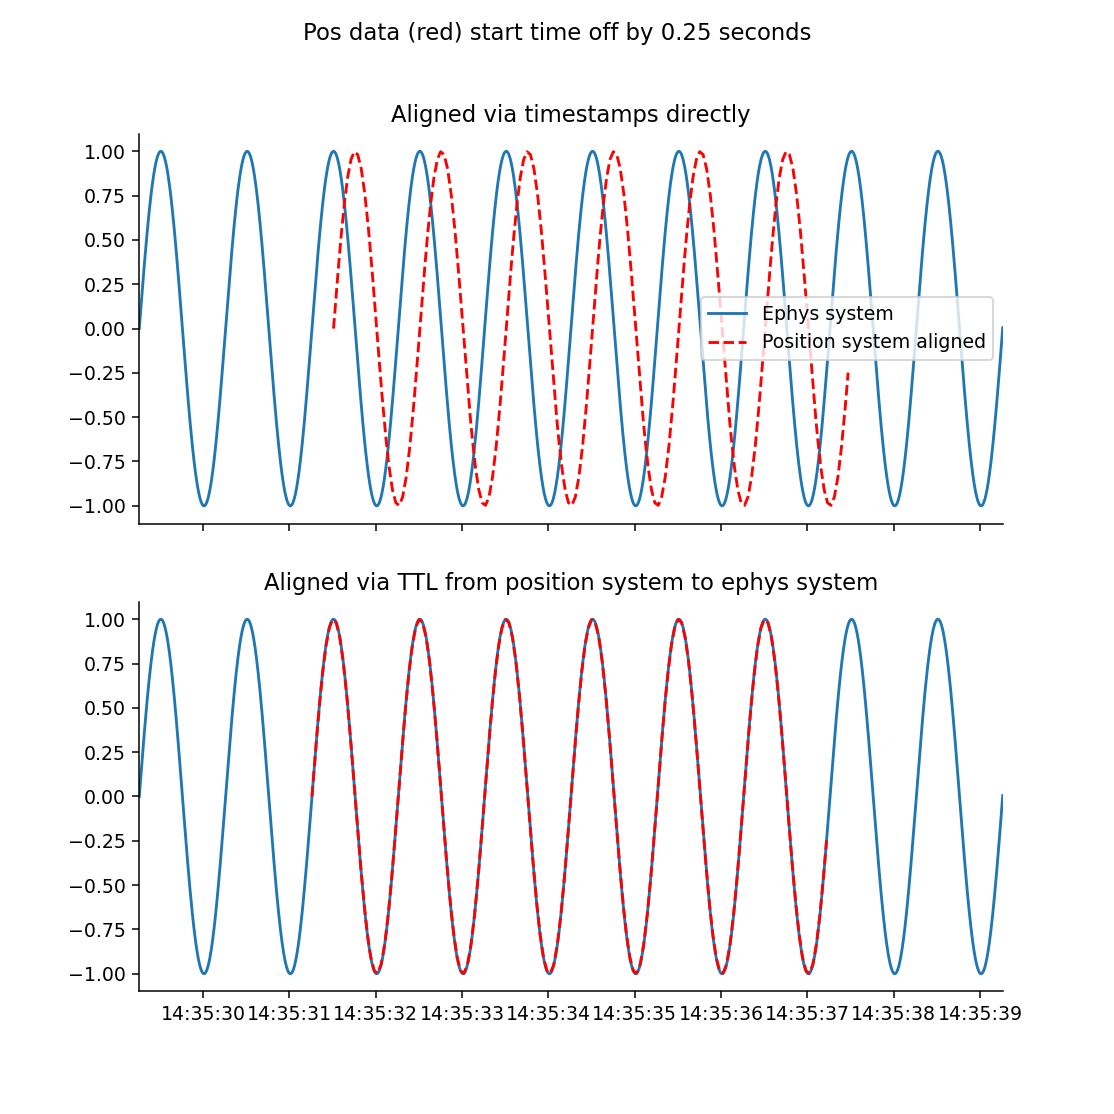

In [8]:
## First, ID TTL time as start of position tracking
TTLtime = tpos_start_second.iloc[0]

## offset times in position data by 0.25 seconds
tpos_start_second_jitter = tpos_start_second + pd.Timedelta(0.25, unit='sec')

# First, align times by timestamps as usual
time_aligned_direct, data_aligned_direct = align_data(t_ephys, tpos_start_second_jitter, data_pos_start_second)

# Now align times by TTLtime in ephys system
time_alignedTTL, data_alignedTTL = align_data(t_ephys, tpos_start_second_jitter, data_pos_start_second,
                                       t_align_ref=TTLtime, t_align_data='start')

# First plot jittered data directly aligned by timestamps
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True)
fig.set_size_inches([6, 6])
fig.suptitle('Pos data (red) start time off by 0.25 seconds')
ax[0].plot(t_ephys, data_ephys)
ax[0].set_xlim([t_ephys.iloc[0], t_ephys.iloc[10*SRlfp]])  # zoom into first 10 seconds
ax[0].plot(time_aligned_direct, data_aligned_direct, 'r--')
ax[0].set_title('Aligned via timestamps directly')
ax[0].legend(['Ephys system', 'Position system aligned'])

# Now, plot jittered data aligned via TTL
ax[1].plot(t_ephys, data_ephys)
ax[1].plot(time_alignedTTL, data_alignedTTL, 'r--')
ax[1].set_title('Aligned via TTL from position system to ephys system')

sns.despine(fig=fig)


Now try the opposite - ephys system started AFTER position system.

No alignment events input, aligning by timestamps directly


<IPython.core.display.Javascript object>


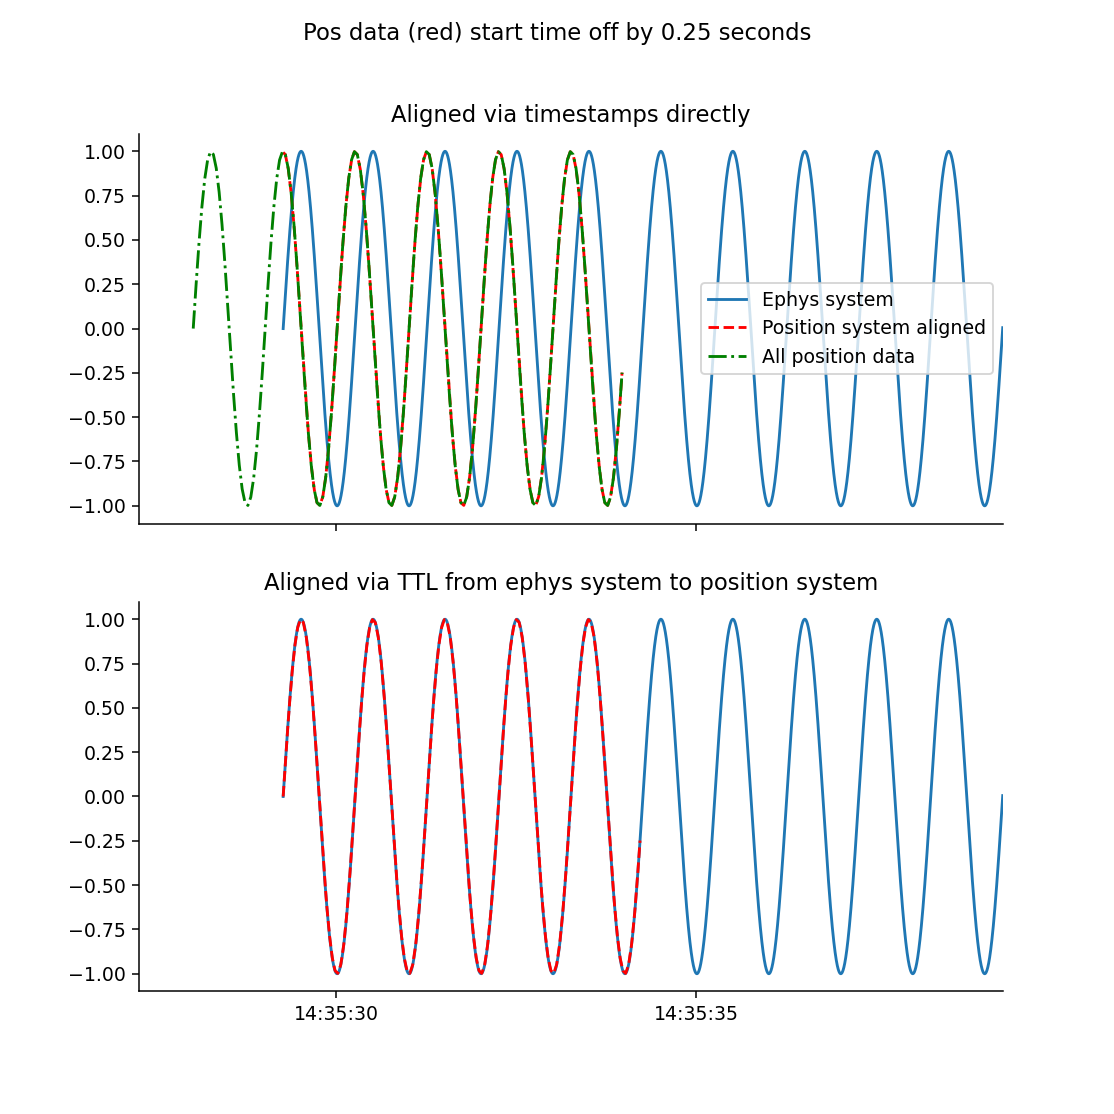

In [9]:
## offset times in position data by 3 seconds - position system now starts 1 second BEFORE ephys
tpos_start_first = tpos_start_second + pd.Timedelta(-3, unit='sec')

## Now introduce a 0.25 second start time inaccuracy
tpos_start_first_jitter = tpos_start_first + pd.Timedelta(-0.25, unit='sec')
data_pos_start_first = data_pos_start_second

##Last, ID TTL time as start of ephys which occurs 1 second after position starts
TTLtime = tpos_start_first_jitter.iloc[1*SRpos]

# First, align times by timestamps as usual
time_aligned_direct, data_aligned_direct = align_data(t_ephys, tpos_start_first_jitter, data_pos_start_first)

# Now align times by TTLtime in ephys system
time_alignedTTL, data_alignedTTL = align_data(t_ephys, tpos_start_first_jitter, data_pos_start_first,
                                       t_align_ref='start', t_align_data=TTLtime)

# First plot jittered data directly aligned by timestamps
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True)
fig.set_size_inches([6, 6])
fig.suptitle('Pos data (red) start time off by 0.25 seconds')
ax[0].plot(t_ephys, data_ephys)
ax[0].set_xlim([t_ephys.iloc[0] - pd.Timedelta(2, unit='sec'), t_ephys.iloc[10*SRlfp]])  # zoom into first 10 seconds
ax[0].plot(time_aligned_direct, data_aligned_direct, 'r--')
ax[0].plot(tpos_start_first_jitter, data_pos_start_first, 'g-.')
ax[0].set_title('Aligned via timestamps directly')
ax[0].legend(['Ephys system', 'Position system aligned', 'All position data'])

# Now, plot jittered data aligned via TTL
ax[1].plot(t_ephys, data_ephys)
ax[1].plot(time_alignedTTL, data_alignedTTL, 'r--')
ax[1].set_title('Aligned via TTL from ephys system to position system')

sns.despine(fig=fig)


Sweet! Ok, now let's say we have a TTL from some OTHER system that goes to both the position and ephys system.

No alignment events input, aligning by timestamps directly


<IPython.core.display.Javascript object>


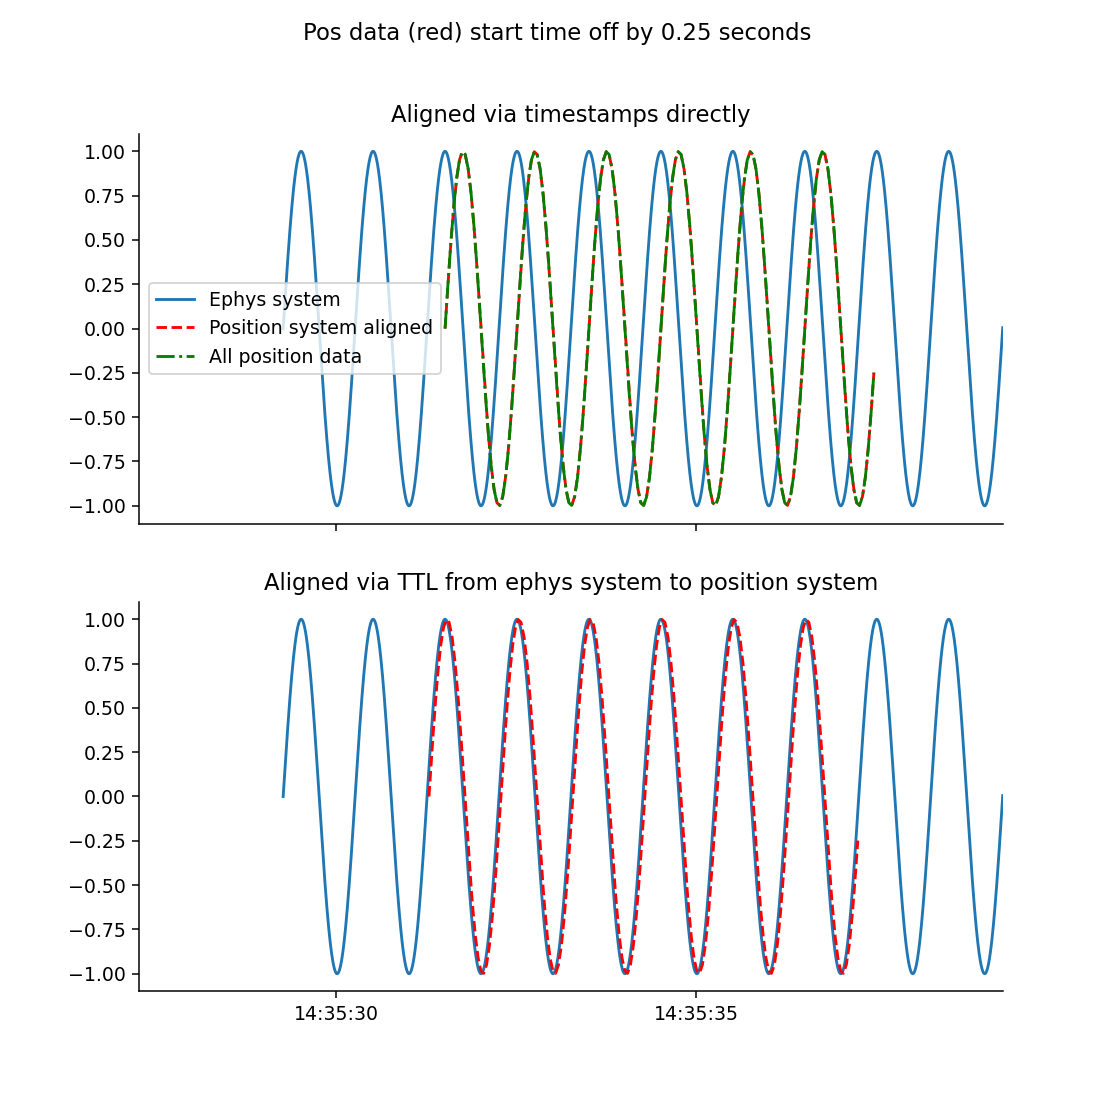

In [15]:
# Assume we start the ephys system first, then the position system 2 seconds later, 
# then send a TTL 0.67 seconds after that.
TTLoe = t_ephys.iloc[int(2.66666666*SRlfp)]
TTLpos = tpos_start_second_jitter.iloc[int(0.66666666*SRpos)]

# First, align times by timestamps as usual
time_aligned_direct, data_aligned_direct = align_data(t_ephys, tpos_start_second_jitter, data_pos_start_second)

# Now align times by common TTL to both systems
time_alignedTTL, data_alignedTTL = align_data(t_ephys, tpos_start_second_jitter, data_pos_start_first,
                                       t_align_ref=TTLoe, t_align_data=TTLpos)

# First plot jittered data directly aligned by timestamps
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True)
fig.set_size_inches([6, 6])
fig.suptitle('Pos data (red) start time off by 0.25 seconds')
ax[0].plot(t_ephys, data_ephys)
ax[0].set_xlim([t_ephys.iloc[0] - pd.Timedelta(2, unit='sec'), t_ephys.iloc[10*SRlfp]])  # zoom into first 10 seconds
ax[0].plot(time_aligned_direct, data_aligned_direct, 'r--')
ax[0].plot(tpos_start_second_jitter, data_pos_start_second, 'g-.')
ax[0].set_title('Aligned via timestamps directly')
ax[0].legend(['Ephys system', 'Position system aligned', 'All position data'])

# Now, plot jittered data aligned via TTL
ax[1].plot(t_ephys, data_ephys)
ax[1].plot(time_alignedTTL, data_alignedTTL, 'r--')
ax[1].set_title('Aligned via TTL from ephys system to position system')

sns.despine(fig=fig)

Ok, so things look pretty good! There is a super small offset for the last plot above, but it's on the order of SRpos, so there's not much you can do.